In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy
from scipy.optimize import curve_fit

from climada.hazard.low_flow import LowFlow

from climada.entity import ImpactFunc, ImpactFuncSet
from climada.entity.exposures import Exposures
from climada.engine import Impact
import datetime


# New Attempt to get impact functions, using historical events

### to do: 
###            1. load hazard & exposures for the years& regions found in the literature research
###            2. change sloap of impact function and calculate impacts until equivalent loss of production is found


In [17]:
#function to get exposures
wri_power_plants_path = '/home/zelie/Python_projects/low_flow/data/exposure/global_power_plant_database.csv'


def load_exposure(bbox=[-180, -90, 180, 90], exp_path=wri_power_plants_path, primary_fuel='Nuclear'):
    """load exposure data from CSV
    Here, we use WRI power plant data from
    https://www.wri.org/publication/global-power-plant-database"""
    exp_df = pd.read_csv(exp_path)
    if primary_fuel:
        exp_df = exp_df[exp_df.primary_fuel==primary_fuel]
    # europe:
    exp_df = exp_df[exp_df.longitude>bbox[0]]
    exp_df = exp_df[exp_df.longitude<bbox[2]]
    exp_df = exp_df[exp_df.latitude>bbox[1]]
    exp_df = exp_df[exp_df.latitude<bbox[3]]
    exp_df['gen_mean']=exp_df[["generation_gwh_2013", "generation_gwh_2014", "generation_gwh_2015", "generation_gwh_2016", "generation_gwh_2017"]].mean(axis=1)
    exp_df['value']=exp_df[["gen_mean", "estimated_generation_gwh"]].mean(axis=1)
    # exp_df['value'] = exp_df.capacity_mw # provide value in MegaWatt
    
    #exp_df['latitude'] = 
    #exp_df['longitude'] = 
    exp_df['if_'] = 1
    exp_df['if_LF'] = 1
    # exp_df = exp_df.drop(columns=['country', 'name', 'gppd_idnr',
    #    'latitude', 'longitude', 'primary_fuel', 'owner', 'source', 'url',
    #    'geolocation_source', 'wepp_id', 'year_of_capacity_data',
    #    'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015',
    #    'generation_gwh_2016', 'generation_gwh_2017',
    #    'estimated_generation_gwh', 'value', 'value_unit', 'if_TC', 'geometry'])
    

    # Generate Exposures from exposure-DataFranme
    exp_df = Exposures(exp_df)
    exp_df.value_unit = 'GWh'
    exp_df.ref_year = 2005
    exp_df.set_geometry_points() # set geometry attribute (shapely Points) from GeoDataFrame from latitude and longitude
    print('\n' + '\x1b[1;03;30;30m' + 'check method logs:' + '\x1b[0m')
    exp_df.check() # puts metadata that has not been assigned
    return exp_df

In [251]:
# function to get impact functions
def init_IFS_linear(s):
    """define impact function imp_fun and return impact function set (IFS)"""
    x0 = np.linspace(1,600,100)
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'LF'
    imp_fun.id = 1
    imp_fun.name = 'Low flow business interruption'
    imp_fun.intensity_unit = 'days'
    imp_fun.intensity = x0
    imp_fun.mdd = s*x0
    imp_fun.mdd[imp_fun.mdd>1]=1
    if s<=1/365:
        imp_fun.mdd[imp_fun.intensity>365] = s*x0[imp_fun.intensity>365]    
    else:
        imp_fun.mdd[imp_fun.intensity>365] = 1/365*x0[imp_fun.intensity>365]  

 # loss to annual operation
    imp_fun.paa = imp_fun.intensity * 0 + 1
   
    #imp_fun.paa[imp_fun.intensity<mdm] = 0
    imp_fun.check()
    IFS = ImpactFuncSet()
    IFS.append(imp_fun)
    return IFS

historical_data = pd.read_excel('historical_impacts.xlsx')


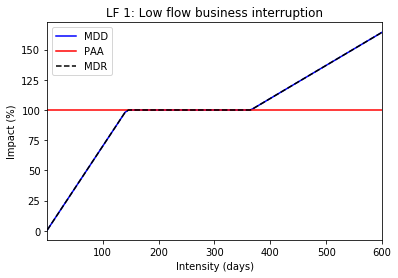

In [252]:
IFS_lf = init_IFS_linear(0.007)
IFS_lf.plot()

In [44]:
## function load hazards

def make_hazard(percentile,yearrange,gh_model,cl_model,bbox):
    input_dir = '../data/isimip_data/'

    min_days_per_month = 5

    fn_str_var= 'co2_dis_global_daily'
    scenario = 'hist'
    soc = 'pressoc'
    yearrange_ref=[1981,2005]
    min_intensity=5
    min_number_cells=16

    hazard = LowFlow()
    hazard.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                            cl_model=cl_model,  bias_correction = 'nobc',scenario=scenario, scenario_ref=scenario, soc=soc, soc_ref=soc, keep_dis_data = True, min_days_per_month=min_days_per_month,\
                                min_intensity=min_intensity, min_number_cells=min_number_cells)

    return hazard

In [112]:
hazard_2_5 = LowFlow()
hazard_2_5 = make_hazard(2.5,[2000,2010],'h08','gswp3', [-15,30,50,72])
hazard_2_5.check()


GETTING STARTED!
2020-07-01 16:01:23,456 - climada.hazard.low_flow - INFO - Computing threshold value per grid cell for Q2, 1981-2005
2020-07-01 16:01:44,721 - climada.hazard.centroids.centr - INFO - Setting geometry points.
2020-07-01 16:02:29,849 - climada.hazard.low_flow - INFO - Filtering events: 100 events remaining


In [84]:
hazard_10 = LowFlow()
hazard_10 = make_hazard(10,[2000,2010],'h08','gswp3', [-15,30,50,72])
hazard_10.check()

GETTING STARTED!
2020-07-01 15:36:21,444 - climada.hazard.low_flow - INFO - Computing threshold value per grid cell for Q10, 1981-2005
2020-07-01 15:36:43,809 - climada.hazard.centroids.centr - INFO - Setting geometry points.
2020-07-01 15:38:54,804 - climada.hazard.low_flow - INFO - Filtering events: 132 events remaining


In [34]:
#load all exposures of hydro power plants
hydro = load_exposure(primary_fuel='Hydro')
nuclear = load_exposure(primary_fuel='Nuclear')

2020-07-01 14:55:18,705 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-07-01 14:55:18,927 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-01 14:55:18,927 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-07-01 14:55:18,927 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-07-01 14:55:18,928 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-01 14:55:18,928 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-01 14:55:18,928 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-01 14:55:18,929 - climada.entity.exposures.base - INFO - cover not set.
2020-07-01 14:55:18,929 - climada.entity.exposures.base - INFO - category_id not set.
2020-07-01 14:55:18,929 - climada.entity.exposures.base - INFO - region_id not set.
2020-07-01 14:55:19,087 - cl

# First testing some individual events

# Spain 2005 Drought

In Spain, the 2005 drought led to a reduction of 36% in national hydroelectric power
production (equivalent to 12 876 GWh), with respect to the past five year average. The
decrease in hydraulic and nuclear production has been compensated by an increase in fuel-gas
plant production and combined cycles that increased their production by respectively 28% and
66%, compared to 2004. This extra production led to an additional cost of 713 Mio €. 
source: https://ec.europa.eu/environment/water/quantity/pdf/comm_droughts/2nd_int_report.pdf p.45

In [352]:
date0 = '2005-01-01'
daten = '2006-01-01' 
hazard_2_5.select(date=(date0,daten))
hazard_10.select(date=(date0,daten))

In [353]:
hydro_spain = hydro[hydro['country']=='ESP']
hydro_spain = Exposures(hydro_spain)
hydro_spain.check()

date0 = '2005-01-01'
daten = '2006-01-01' 

IFS_lf = init_IFS_linear(0.007)

imp_spain_2005 = Impact()
imp_spain_2005.calc(hydro_spain, IFS_lf, hazard_2_5.select(date=(date0,daten)))
print(imp_spain_2005.at_event.sum()/(imp_spain_2005.tot_value)*100)

2020-07-01 18:40:57,111 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-01 18:40:57,112 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-01 18:40:57,113 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-01 18:40:57,113 - climada.entity.exposures.base - INFO - cover not set.
2020-07-01 18:40:57,113 - climada.entity.exposures.base - INFO - category_id not set.
2020-07-01 18:40:57,113 - climada.entity.exposures.base - INFO - region_id not set.
2020-07-01 18:40:57,117 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:40:57,119 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 11 events.
0.0


In [354]:
# trying with the 10th percentile

IFS_lf = init_IFS_linear(0.014)

date0 = '2005-01-01'
daten = '2006-01-01' 
imp_spain_2005 = Impact()
imp_spain_2005.calc(hydro_spain, IFS_lf, hazard_10.select(date=(date0,daten)))
print(imp_spain_2005.at_event.sum()/(imp_spain_2005.tot_value)*100)

2020-07-01 18:40:59,106 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:40:59,108 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 12 events.
36.19198512026091


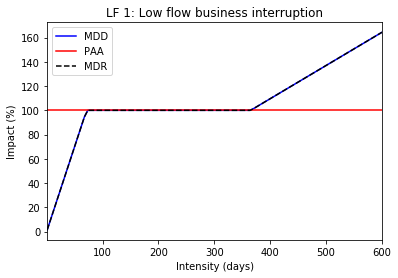

In [355]:
IFS_lf.plot() 

### Appears to work with the 10th percentile but the steepness of the impact function doesn't seem very realistic

## Germany 2003 ->11% loss of production

In [356]:
nuclear = load_exposure(primary_fuel='Nuclear')
nuclear_germany = nuclear[nuclear['country_long']=='Germany']
nuclear_germany = Exposures(nuclear_germany)
nuclear_germany.check()

date0 = '2003-01-01'
daten = '2004-01-01' 

IFS_lf = init_IFS_linear(0.002)

imp_germany_2003 = Impact()
imp_germany_2003.calc(nuclear_germany, IFS_lf, hazard_2_5.select(date=(date0,daten)))
print(imp_germany_2003.at_event.sum()/(imp_germany_2003.tot_value)*100)

2020-07-01 18:41:07,378 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-07-01 18:41:07,386 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-01 18:41:07,386 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-07-01 18:41:07,387 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-07-01 18:41:07,387 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-01 18:41:07,387 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-01 18:41:07,388 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-01 18:41:07,388 - climada.entity.exposures.base - INFO - cover not set.
2020-07-01 18:41:07,389 - climada.entity.exposures.base - INFO - category_id not set.
2020-07-01 18:41:07,389 - climada.entity.exposures.base - INFO - region_id not set.
2020-07-01 18:41:07,393 - cl

## checking normal yrs

In [357]:
nuclear = load_exposure(primary_fuel='Nuclear')
nuclear_germany = nuclear[nuclear['country_long']=='Germany']
nuclear_germany = Exposures(nuclear_germany)
nuclear_germany.check()

date0 = '2004-01-01'
daten = '2010-01-01' 

IFS_lf = init_IFS_linear(0.007)

imp_germany_2003 = Impact()
imp_germany_2003.calc(nuclear_germany, IFS_lf, hazard_2_5.select(date=(date0,daten)))
print(imp_germany_2003.at_event.sum()/(imp_germany_2003.tot_value*6)*100)

2020-07-01 18:41:09,673 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-07-01 18:41:09,681 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-01 18:41:09,681 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-07-01 18:41:09,682 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-07-01 18:41:09,682 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-01 18:41:09,683 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-01 18:41:09,683 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-01 18:41:09,683 - climada.entity.exposures.base - INFO - cover not set.
2020-07-01 18:41:09,684 - climada.entity.exposures.base - INFO - category_id not set.
2020-07-01 18:41:09,684 - climada.entity.exposures.base - INFO - region_id not set.
2020-07-01 18:41:09,688 - cl

# France 2003 & 2006

## Les pertes de production ont atteint 5,5 TWh en 2003 et 2,5 TWh en 2006
https://www.sfen.org/rgn/adapter-centrales-nucleaires-changement-climatique

In [360]:
nuclear = load_exposure(primary_fuel='Nuclear')
nuclear_france = nuclear[nuclear['country_long']=='France']
nuclear_france = Exposures(nuclear_france)
nuclear_france.check()

date0 = '2003-01-01'
daten = '2004-01-01' 

IFS_lf = init_IFS_linear(0.0005)

imp_france_2003 = Impact()
imp_france_2003.calc(nuclear_france, IFS_lf, hazard_2_5.select(date=(date0,daten)))
print(imp_france_2003.at_event.sum()/1000) #(/1000 because the data is in GWh)

2020-07-01 18:41:45,675 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-07-01 18:41:45,683 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-01 18:41:45,683 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-07-01 18:41:45,684 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-07-01 18:41:45,684 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-01 18:41:45,685 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-01 18:41:45,685 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-01 18:41:45,686 - climada.entity.exposures.base - INFO - cover not set.
2020-07-01 18:41:45,687 - climada.entity.exposures.base - INFO - category_id not set.
2020-07-01 18:41:45,688 - climada.entity.exposures.base - INFO - region_id not set.
2020-07-01 18:41:45,691 - cl

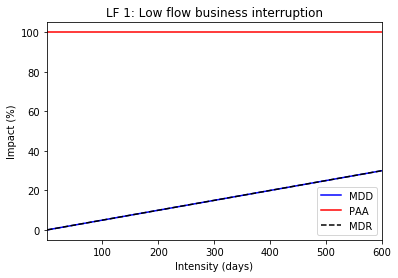

In [361]:
IFS_lf.plot() #very flat

In [362]:
nuclear = load_exposure(primary_fuel='Nuclear')
nuclear_france = nuclear[nuclear['country_long']=='France']
nuclear_france = Exposures(nuclear_france)
nuclear_france.check()

date0 = '2006-01-01'
daten = '2007-01-01' 

IFS_lf = init_IFS_linear(0.002)

imp_france_2003 = Impact()
imp_france_2003.calc(nuclear_france, IFS_lf, hazard_2_5.select(date=(date0,daten)))
print(imp_france_2003.at_event.sum()/1000)

2020-07-01 18:41:49,305 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-07-01 18:41:49,313 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-01 18:41:49,314 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-07-01 18:41:49,314 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-07-01 18:41:49,314 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-01 18:41:49,315 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-01 18:41:49,315 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-01 18:41:49,315 - climada.entity.exposures.base - INFO - cover not set.
2020-07-01 18:41:49,317 - climada.entity.exposures.base - INFO - category_id not set.
2020-07-01 18:41:49,318 - climada.entity.exposures.base - INFO - region_id not set.
2020-07-01 18:41:49,321 - cl

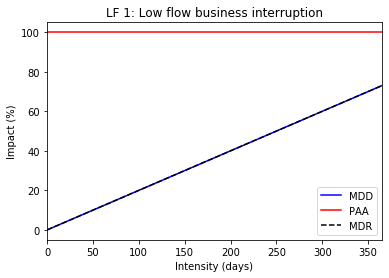

In [141]:
IFS_lf_t3.plot()

# Europe 2003 6.6% loss hydro, 4.7% nuclear

In [363]:
#nuclear
date0 = '2003-01-01'
daten = '2004-01-01' 

IFS_lf = init_IFS_linear(0.0045)

imp_eu_2003 = Impact()
imp_eu_2003.calc(nuclear, IFS_lf, hazard_2_5.select(date=(date0,daten)))
print(imp_eu_2003.at_event.sum()/(imp_eu_2003.tot_value)*100)

2020-07-01 18:41:55,073 - climada.entity.exposures.base - INFO - Matching 198 exposures with 10920 centroids.
2020-07-01 18:41:55,075 - climada.engine.impact - INFO - Calculating damage for 147 assets (>0) and 7 events.
4.796902489819871


In [364]:
#hydro
date0 = '2003-01-01'
daten = '2004-01-01' 

IFS_lf = init_IFS_linear(0.0084)

imp_eu_2003 = Impact()
imp_eu_2003.calc(hydro, IFS_lf, hazard_2_5.select(date=(date0,daten)))
print(imp_eu_2003.at_event.sum()/(imp_eu_2003.tot_value)*100)

2020-07-01 18:41:56,521 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:41:56,522 - climada.engine.impact - INFO - Calculating damage for 4632 assets (>0) and 7 events.
6.413870132622197


# now making a function which looks for the right slope of the if of each event for different datasets

In [255]:

def if_finder(historical_data, hazard, input_dir=None, centroids=None,
                    bbox=None, percentile=2.5, min_intensity=5, min_number_cells=16,
                    min_days_per_month=5, yearrange_ref=[1981,2010],
                    gh_model='h08', cl_model='gswp3',
                    scenario='hist', scenario_ref='hist', soc='pressoc', \
                    fn_str_var='co2_dis_global_daily', bias_correction = 'nobc'):
    
    
    
    energies = historical_data['Energy'].unique()
    exposures = {}
    for e in energies:
        exposures[e] = load_exposure(primary_fuel=e)
    
    slope_list = []
    for index, row in historical_data.iterrows():
        year0 = historical_data['date0'][index].year
        yearn = historical_data['daten'][index].year
        yearrange = [year0,yearn]
        exposuresn = exposures[historical_data['Energy'][index]]
        country = historical_data['Country'][index].split(',')
        exposuresn = exposuresn[exposuresn.country_long.isin(country)]
        exposuresn = Exposures(exposuresn)
        exposuresn.check()
        hazardn = hazard.select(date=(historical_data['date0'][index].toordinal(),historical_data['daten'][index].toordinal()))
        slope=0.0005
        impacts_sum = 0
        while historical_data['loss'][index]>impacts_sum:
            print(impacts_sum)
            slope = slope + 0.0005
            if slope > 0.01: # break in case the slope becomes too large to make sense
                slope = 'NA'
                break
            impact_function = init_IFS_linear(slope)
            impact = Impact()
            impact.calc(exposuresn, impact_function, hazardn)
            if historical_data['unit'][index]=='percentage':
                impacts_sum = impact.at_event.sum()/(impact.tot_value*(yearn-year0))*100
            else:
                impacts_sum = impact.at_event.sum()
        slope_list.append(slope)
    historical_data["_".join(['slope_if',gh_model,cl_model])] = slope_list
    return(historical_data)
   

In [325]:
historical_data = pd.read_excel('historical_impacts.xlsx')


In [326]:
historical_data

,Unnamed: 0,Unnamed: 0.1,Energy,Country,date0,daten,loss,unit,slope_if_lpjml_gswp3,slope_if_h08_gswp3,slope_if_h08_princeton,slope_if_lpjml_wfdei,if_slope
0,0,0,Hydro,Portugal,2005-01-01,2006-01-01,21.0,percentage,NaN,NaN,NaN,0.003,NaN
1,1,1,Hydro,Spain,2005-01-01,2006-01-01,37.5,percentage,NaN,NaN,NaN,NaN,NaN
2,2,2,Hydro,France,2005-01-01,2006-01-01,10000.0,Gwh,NaN,0.003,0.003,0.003,0.0030
3,3,3,Hydro,Albania,2003-01-01,2004-01-01,33.0,percentage,NaN,NaN,NaN,NaN,NaN
4,4,4,Hydro,Spain,2004-01-01,2008-01-01,17.0,percentage,NaN,NaN,NaN,NaN,NaN
5,5,5,Hydro,"Finland, Sweden, Norway",2002-01-01,2003-01-01,7.8,percentage,0.007,0.002,0.002,NaN,0.0045
6,6,6,Hydro,"Finland, Sweden, Norway",1996-01-01,1997-01-01,21.3,percentage,NaN,0.006,0.004,NaN,0.0060
7,7,7,Hydro,Spain,1992-01-01,1994-01-01,14.5,percentage,NaN,NaN,NaN,NaN,NaN
8,8,8,Nuclear,France,2003-01-01,2004-01-01,5500.0,Gwh,0.002,0.002,0.002,NaN,0.0020
9,9,9,Nuclear,France,2006-01-01,2007-01-01,2500.0,Gwh,0.002,0.002,0.002,0.002,0.0020


In [330]:
historical_data = pd.read_excel('historical_impacts.xlsx')

input_dir = '../data/isimip_data/'
year0 = np.min(historical_data['date0']).year
yearn = np.max(historical_data['daten']).year
yearrange=[year0,yearn]


min_days_per_month = 5
percentile = 2.5
#gh_model = 'h08'
cl_model = 'gswp3'
fn_str_var= 'co2_dis_global_daily'
scenario = 'hist'
soc = 'pressoc'
yearrange_ref=[1981,2005]
bbox = [-15,30,50,72]
min_intensity=5
min_number_cells=16

for gh_model in ['lpjml','h08']: #matsiro does not have any data for soc='pressoc'
    for cl_model in ['gswp3']:
        
        print(gh_model)
        hazard = LowFlow()
        hazard.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                                cl_model=cl_model,  bias_correction = 'nobc',scenario=scenario, scenario_ref=scenario, soc=soc, soc_ref=soc, keep_dis_data = True, min_days_per_month=min_days_per_month,\
                                    min_intensity=min_intensity, min_number_cells=min_number_cells)


        historical_data = if_finder(historical_data.loc[0:12], hazard, input_dir=input_dir, bbox=bbox, gh_model=gh_model,cl_model=cl_model)

lpjml
GETTING STARTED!
2020-07-01 18:25:09,402 - climada.hazard.low_flow - INFO - Computing threshold value per grid cell for Q2, 1981-2005
2020-07-01 18:25:31,741 - climada.hazard.centroids.centr - INFO - Setting geometry points.
2020-07-01 18:27:30,800 - climada.hazard.low_flow - INFO - Filtering events: 197 events remaining
2020-07-01 18:27:30,935 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-07-01 18:27:31,134 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-01 18:27:31,135 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-07-01 18:27:31,135 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-07-01 18:27:31,135 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-01 18:27:31,136 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-01 18:27:31,136 - climada.

8.9189514146367
2020-07-01 18:27:31,388 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27:31,389 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 15 events.
9.51354817561248
2020-07-01 18:27:31,392 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27:31,393 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 15 events.
10.10814493658826
2020-07-01 18:27:31,395 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27:31,396 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 15 events.
10.700078991840694
2020-07-01 18:27:31,399 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27:31,400 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 15 events.
11.278893648420084
2020-07-01 18:27:31,405 - climada.entity.exposures.

2020-07-01 18:27:31,526 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 13 events.
0.0
2020-07-01 18:27:31,528 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27:31,529 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 13 events.
0.0
2020-07-01 18:27:31,532 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27:31,533 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 13 events.
0.0
2020-07-01 18:27:31,535 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27:31,536 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 13 events.
0.0
2020-07-01 18:27:31,538 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27:31,539 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 13 events.
0.0
2020-07-01 18:27:31

7.070541321065179
2020-07-01 18:27:31,653 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27:31,654 - climada.engine.impact - INFO - Calculating damage for 95 assets (>0) and 14 events.
2020-07-01 18:27:31,657 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-01 18:27:31,658 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-01 18:27:31,658 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-01 18:27:31,658 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-01 18:27:31,659 - climada.entity.exposures.base - INFO - cover not set.
2020-07-01 18:27:31,659 - climada.entity.exposures.base - INFO - category_id not set.
2020-07-01 18:27:31,660 - climada.entity.exposures.base - INFO - region_id not set.
0
2020-07-01 18:27:31,663 - climada.entity.exposures.base - INFO - Matching 95 exposures with 10920 centroids.
2020-07-01 18:27:31

0.0
2020-07-01 18:27:31,780 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27:31,781 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 24 events.
0.0
2020-07-01 18:27:31,784 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27:31,785 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 24 events.
0.0
2020-07-01 18:27:31,788 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27:31,789 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 24 events.
0.0
2020-07-01 18:27:31,791 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27:31,791 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 24 events.
0.0
2020-07-01 18:27:31,794 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27

2020-07-01 18:27:31,911 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 13 events.
9.586960115072502
2020-07-01 18:27:31,915 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27:31,916 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 13 events.
11.184786800917918
2020-07-01 18:27:31,919 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:27:31,920 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 13 events.
h08
GETTING STARTED!
2020-07-01 18:27:44,025 - climada.hazard.low_flow - INFO - Computing threshold value per grid cell for Q2, 1981-2005
2020-07-01 18:28:07,075 - climada.hazard.centroids.centr - INFO - Setting geometry points.
2020-07-01 18:29:19,541 - climada.hazard.low_flow - INFO - Filtering events: 146 events remaining
2020-07-01 18:29:19,675 - climada.util.coordinates - INFO - Setting geometry points.

check method lo

2020-07-01 18:29:20,102 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 11 events.
0.0
2020-07-01 18:29:20,106 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:29:20,107 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 11 events.
0.0
2020-07-01 18:29:20,109 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:29:20,110 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 11 events.
0.0
2020-07-01 18:29:20,112 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:29:20,113 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 11 events.
0.0
2020-07-01 18:29:20,116 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:29:20,118 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 11 events.
0.0
2020-07-0

2020-07-01 18:29:20,234 - climada.entity.exposures.base - INFO - category_id not set.
2020-07-01 18:29:20,235 - climada.entity.exposures.base - INFO - region_id not set.
0
2020-07-01 18:29:20,240 - climada.entity.exposures.base - INFO - Matching 7 exposures with 10920 centroids.
2020-07-01 18:29:20,242 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.
0.0
2020-07-01 18:29:20,244 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:29:20,245 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.
0.0
2020-07-01 18:29:20,247 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:29:20,248 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 7 events.
0.0
2020-07-01 18:29:20,250 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:29:20,251 - climada.engine.impact - INFO - Calculating dam

0.0
2020-07-01 18:29:20,378 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:29:20,379 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 40 events.
0.0
2020-07-01 18:29:20,381 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:29:20,382 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 40 events.
0.0
2020-07-01 18:29:20,387 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-01 18:29:20,387 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-01 18:29:20,387 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-01 18:29:20,388 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-01 18:29:20,388 - climada.entity.exposures.base - INFO - cover not set.
2020-07-01 18:29:20,388 - climada.entity.exposures.base - INFO - category_id not set.
2020

0.0
2020-07-01 18:29:20,513 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:29:20,515 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 12 events.
0.0
2020-07-01 18:29:20,518 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:29:20,519 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 12 events.
0.0
2020-07-01 18:29:20,522 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:29:20,523 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 12 events.
0.0
2020-07-01 18:29:20,526 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:29:20,527 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 12 events.
0.0
2020-07-01 18:29:20,530 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:29

In [331]:
for gh_model in ['h08']:
    for cl_model in ['princeton']:

        print(gh_model)
        hazard = LowFlow()
        hazard.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                                cl_model=cl_model,  bias_correction = 'nobc',scenario=scenario, scenario_ref=scenario, soc=soc, soc_ref=soc, keep_dis_data = True, min_days_per_month=min_days_per_month,\
                                    min_intensity=min_intensity, min_number_cells=min_number_cells)


        historical_data = if_finder(historical_data.loc[0:12], hazard, input_dir=input_dir, bbox=bbox, gh_model=gh_model,cl_model=cl_model)

h08
GETTING STARTED!
2020-07-01 18:29:32,560 - climada.hazard.low_flow - INFO - Computing threshold value per grid cell for Q2, 1981-2005
2020-07-01 18:29:56,374 - climada.hazard.centroids.centr - INFO - Setting geometry points.
2020-07-01 18:31:16,845 - climada.hazard.low_flow - INFO - Filtering events: 159 events remaining
2020-07-01 18:31:16,978 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-07-01 18:31:17,183 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-01 18:31:17,184 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-07-01 18:31:17,184 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-07-01 18:31:17,185 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-01 18:31:17,185 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-01 18:31:17,186 - climada.en

0.18538357611043108
2020-07-01 18:31:17,453 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:31:17,454 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 9 events.
0.23172947013803888
2020-07-01 18:31:17,457 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:31:17,458 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 9 events.
0.2780753641656467
2020-07-01 18:31:17,462 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:31:17,463 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 9 events.
0.32442125819325446
2020-07-01 18:31:17,466 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:31:17,467 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 9 events.
0.37076715222086215
2020-07-01 18:31:17,470 - climada.engine.impa

2020-07-01 18:31:17,600 - climada.engine.impact - INFO - Calculating damage for 428 assets (>0) and 9 events.
9057.49197333304
2020-07-01 18:31:17,604 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-01 18:31:17,605 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-01 18:31:17,605 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-01 18:31:17,605 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-01 18:31:17,606 - climada.entity.exposures.base - INFO - cover not set.
2020-07-01 18:31:17,606 - climada.entity.exposures.base - INFO - category_id not set.
2020-07-01 18:31:17,606 - climada.entity.exposures.base - INFO - region_id not set.
0
2020-07-01 18:31:17,610 - climada.entity.exposures.base - INFO - Matching 7 exposures with 10920 centroids.
2020-07-01 18:31:17,613 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 9 events.
0.0
2020-07-01 18

2020-07-01 18:31:17,739 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 38 events.
0.19053998110853268
2020-07-01 18:31:17,741 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:31:17,742 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 38 events.
0.20414997975914223
2020-07-01 18:31:17,746 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:31:17,747 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 38 events.
0.2177599784097517
2020-07-01 18:31:17,751 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:31:17,752 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 38 events.
0.23136997706036116
2020-07-01 18:31:17,755 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:31:17,756 - climada.engine.impact - INFO - Calc

2020-07-01 18:31:17,873 - climada.entity.exposures.base - INFO - region_id not set.
0
2020-07-01 18:31:17,879 - climada.entity.exposures.base - INFO - Matching 124 exposures with 10920 centroids.
2020-07-01 18:31:17,881 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 18 events.
0.0
2020-07-01 18:31:17,885 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:31:17,886 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 18 events.
0.0
2020-07-01 18:31:17,888 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:31:17,890 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 18 events.
0.0
2020-07-01 18:31:17,892 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:31:17,894 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 18 events.
0.0
2020-07-01 18:31:17,896 - climad

In [332]:
for gh_model in ['lpjml']:
    for cl_model in ['wfdei']:

        print(gh_model)
        hazard = LowFlow()
        hazard.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                                cl_model=cl_model,  bias_correction = 'nobc',scenario=scenario, scenario_ref=scenario, soc=soc, soc_ref=soc, keep_dis_data = True, min_days_per_month=min_days_per_month,\
                                    min_intensity=min_intensity, min_number_cells=min_number_cells)


        historical_data = if_finder(historical_data.loc[0:12], hazard, input_dir=input_dir, bbox=bbox, gh_model=gh_model,cl_model=cl_model)

lpjml
GETTING STARTED!
2020-07-01 18:31:29,961 - climada.hazard.low_flow - INFO - Computing threshold value per grid cell for Q2, 1981-2005
2020-07-01 18:31:52,240 - climada.hazard.centroids.centr - INFO - Setting geometry points.
2020-07-01 18:33:51,383 - climada.hazard.low_flow - INFO - Filtering events: 196 events remaining
2020-07-01 18:33:51,523 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-07-01 18:33:51,829 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-07-01 18:33:51,829 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-07-01 18:33:51,829 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-07-01 18:33:51,830 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-07-01 18:33:51,830 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-01 18:33:51,830 - climada.

5.660128124181861
2020-07-01 18:33:52,079 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,080 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 15 events.
6.037469999127318
2020-07-01 18:33:52,084 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,085 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 15 events.
6.412653650524858
2020-07-01 18:33:52,088 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,089 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 15 events.
6.774216594222892
2020-07-01 18:33:52,091 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,092 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 15 events.
7.131759911516888
2020-07-01 18:33:52,095 - climada.entity.exposures

2020-07-01 18:33:52,230 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 12 events.
0.0
2020-07-01 18:33:52,233 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,235 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 12 events.
0.0
2020-07-01 18:33:52,238 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,239 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 12 events.
0.0
2020-07-01 18:33:52,241 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,242 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 12 events.
0.0
2020-07-01 18:33:52,245 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,246 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 12 events.
0.0
2020-07-01 18:33:52

2.5916560327747753
2020-07-01 18:33:52,358 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,359 - climada.engine.impact - INFO - Calculating damage for 95 assets (>0) and 9 events.
3.2395700409684682
2020-07-01 18:33:52,362 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,363 - climada.engine.impact - INFO - Calculating damage for 95 assets (>0) and 9 events.
3.887484049162162
2020-07-01 18:33:52,366 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,367 - climada.engine.impact - INFO - Calculating damage for 95 assets (>0) and 9 events.
4.535398057355857
2020-07-01 18:33:52,368 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,369 - climada.engine.impact - INFO - Calculating damage for 95 assets (>0) and 9 events.
5.183312065549551
2020-07-01 18:33:52,371 - climada.engine.impact - INFO -

2020-07-01 18:33:52,485 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 26 events.
0.0
2020-07-01 18:33:52,488 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,489 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 26 events.
0.0
2020-07-01 18:33:52,491 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,492 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 26 events.
0.0
2020-07-01 18:33:52,495 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,497 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 26 events.
0.0
2020-07-01 18:33:52,501 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,502 - climada.engine.impact - INFO - Calculating damage for 123 assets (>0) and 26 events.
0.0
2020-07-0

2020-07-01 18:33:52,630 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 12 events.
8.21155984032892
2020-07-01 18:33:52,633 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,634 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 12 events.
9.580153147050408
2020-07-01 18:33:52,638 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,639 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 12 events.
10.948746453771896
2020-07-01 18:33:52,641 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LF
2020-07-01 18:33:52,642 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 12 events.


In [346]:
historical_data['slope_if'] = historical_data.replace('NA',float('nan')).iloc[:,8:12].mean(axis=1)

In [347]:
historical_data

,Unnamed: 0,Unnamed: 0.1,Energy,Country,date0,daten,loss,unit,slope_if_lpjml_gswp3,slope_if_h08_gswp3,slope_if_h08_princeton,slope_if_lpjml_wfdei,if_slope,slope_if
0,0,0,Hydro,Portugal,2005-01-01,2006-01-01,21.0,percentage,0.0035,NA,NA,0.0035,NaN,0.003500
1,1,1,Hydro,Spain,2005-01-01,2006-01-01,37.5,percentage,NA,NA,NA,NA,NaN,NaN
2,2,2,Hydro,France,2005-01-01,2006-01-01,10000.0,Gwh,0.0095,0.0075,NA,NA,0.0030,0.008500
3,3,3,Hydro,Albania,2003-01-01,2004-01-01,33.0,percentage,NA,NA,NA,NA,NaN,NaN
4,4,4,Hydro,Spain,2004-01-01,2008-01-01,17.0,percentage,NA,NA,NA,NA,NaN,NaN
5,5,5,Hydro,"Finland, Sweden, Norway",2002-01-01,2003-01-01,7.8,percentage,0.0025,0.0025,0.0025,0.0065,0.0045,0.003500
6,6,6,Hydro,"Finland, Sweden, Norway",1996-01-01,1997-01-01,21.3,percentage,NA,0.0085,NA,NA,0.0060,0.008500
7,7,7,Hydro,Spain,1992-01-01,1994-01-01,14.5,percentage,NA,NA,NA,NA,NaN,NaN
8,8,8,Nuclear,France,2003-01-01,2004-01-01,5500.0,Gwh,0.001,0.001,0.001,0.001,0.0020,0.001000
9,9,9,Nuclear,France,2006-01-01,2007-01-01,2500.0,Gwh,NA,0.002,0.002,0.005,0.0020,0.003000


Text(0.5, 1.0, 'Thermo')

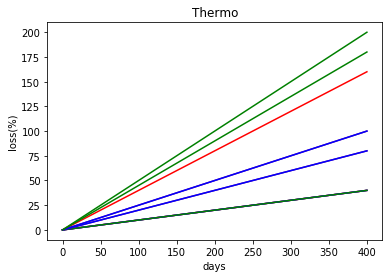

In [348]:
x0 = np.linspace(0,400,20)
fig,ax = plt.subplots()
for index, row in historical_data[historical_data['Energy']=='Nuclear'].iterrows():
    if historical_data['slope_if_lpjml_gswp3'][index] !='NA':
        ax.plot(x0,x0*historical_data['slope_if_lpjml_gswp3'][index]*100,color='Red')
        
    if historical_data['slope_if_h08_gswp3'][index] !='NA':
        ax.plot(x0,x0*historical_data['slope_if_h08_gswp3'][index]*100, color='Purple')    
    
    if historical_data['slope_if_h08_princeton'][index] !='NA':
        ax.plot(x0,x0*historical_data['slope_if_h08_princeton'][index]*100, color='Blue')
        
    if historical_data['slope_if_lpjml_wfdei'][index] !='NA':
        ax.plot(x0,x0*historical_data['slope_if_lpjml_wfdei'][index]*100, color='Green') 
        
ax.set_xlabel('days')
ax.set_ylabel('loss(%)')
ax.set_title('Thermo')

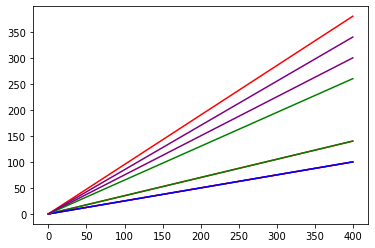

In [349]:
x0 = np.linspace(0,400,20)
fig,ax = plt.subplots()
for index, row in historical_data[historical_data['Energy']=='Hydro'].iterrows():
    if historical_data['slope_if_lpjml_gswp3'][index] !='NA':
        ax.plot(x0,x0*historical_data['slope_if_lpjml_gswp3'][index]*100,color='Red')
        
    if historical_data['slope_if_h08_gswp3'][index] !='NA':
        ax.plot(x0,x0*historical_data['slope_if_h08_gswp3'][index]*100, color='Purple')    
    
    if historical_data['slope_if_h08_princeton'][index] !='NA':
        ax.plot(x0,x0*historical_data['slope_if_h08_princeton'][index]*100, color='Blue')
        
    if historical_data['slope_if_lpjml_wfdei'][index] !='NA':
        ax.plot(x0,x0*historical_data['slope_if_lpjml_wfdei'][index]*100, color='Green')   

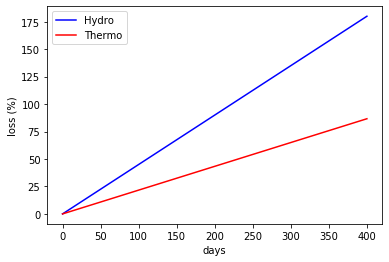

In [350]:
x0 = np.linspace(0,400,20)
fig,ax = plt.subplots()
ax.plot(x0,x0*historical_data['if_slope'][historical_data['Energy']=='Hydro'].mean()*100,color='Blue',label='Hydro')
ax.plot(x0,x0*historical_data['if_slope'][historical_data['Energy']=='Nuclear'].mean()*100,color='Red', label='Thermo')
ax.set_xlabel('days')
ax.set_ylabel('loss (%)')
ax.legend()       

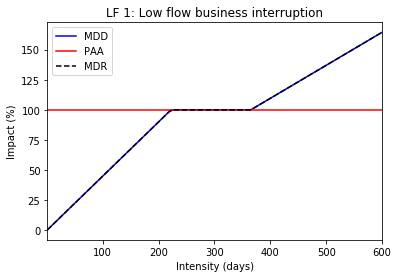

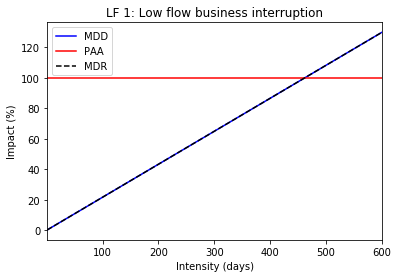

In [351]:
IFS_hydro = init_IFS_linear(historical_data['if_slope'][historical_data['Energy']=='Hydro'].mean())
IFS_thermo = init_IFS_linear(historical_data['if_slope'][historical_data['Energy']=='Nuclear'].mean())
IFS_hydro.plot()
IFS_thermo.plot()